In [ ]:
#import libraries
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'imbalanced-learn', '--quiet'])
print('imbalanced-learn installed successfully')

imbalanced-learn installed successfully


In [ ]:
# Core libraries 
import pandas as pd
import numpy as np

# for Visualisation 
import matplotlib.pyplot as plt
import seaborn as sns

# for Preprocessing 
from sklearn.impute   import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

# for Class-Imbalance Handling 
from imblearn.over_sampling import SMOTE

# for Statistical Tests
from scipy import stats

# for Display settings 
pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid', palette='mako')
plt.rcParams['figure.dpi'] = 110

print('Libraries imported successfully!')

Libraries imported successfully!


In [ ]:
# upload the dataset 

df = pd.read_csv('cybersecurity_intrusion_data.csv')

print(f'Dataset shape: {df.shape}   ({df.shape[0]} rows × {df.shape[1]} columns)')
df.head(10)

Dataset shape: (9537, 11)   (9537 rows × 11 columns)


,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0
5,SID_00006,453,UDP,5,380.471550,AES,0.422486,2,Chrome,1,0
6,SID_00007,815,ICMP,4,728.107165,AES,0.413772,1,Chrome,0,1
7,SID_00008,653,TCP,3,12.599906,DES,0.097719,3,Chrome,1,1
8,SID_00009,406,TCP,2,542.558895,NaN,0.294580,0,Chrome,1,0
9,SID_00010,608,UDP,6,531.944107,NaN,0.424117,1,Chrome,0,0


In [ ]:
# prepropressing:inspect data types & non-null counts 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


In [ ]:
# Descriptive statistics for numerical columns 
df.describe().round(3)

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,attack_detected
count,9537.000,9537.000,9537.000,9537.000,9537.000,9537.000,9537.000
mean,500.431,4.032,792.745,0.331,1.518,0.150,0.447
std,198.379,1.963,786.560,0.177,1.034,0.357,0.497
min,64.000,1.000,0.500,0.002,0.000,0.000,0.000
25%,365.000,3.000,231.953,0.192,1.000,0.000,0.000
50%,499.000,4.000,556.277,0.315,1.000,0.000,0.000
75%,635.000,5.000,1105.381,0.453,2.000,0.000,1.000
max,1285.000,13.000,7190.392,0.924,5.000,1.000,1.000


In [ ]:
# Check missing values 
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_report = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
print(missing_report)

if missing.sum() == 0:
    print('\n✓ No missing values found in this dataset.')
else:
    print(f'\n⚠ Total missing cells: {missing.sum()}')

                     Missing Count  Missing %
session_id                       0       0.00
network_packet_size              0       0.00
protocol_type                    0       0.00
login_attempts                   0       0.00
session_duration                 0       0.00
encryption_used               1966      20.61
ip_reputation_score              0       0.00
failed_logins                    0       0.00
browser_type                     0       0.00
unusual_time_access              0       0.00
attack_detected                  0       0.00

⚠ Total missing cells: 1966


Missing Data Analysis (MCAR vs MNAR)

Even though our dataset has no missing values right now, it is important to understand "why" data could be missing in a real cybersecurity context:

-MCAR (Missing Completely At Random): A sensor crashes randomly == missingness is unrelated to any variable. Safe to use mean/median imputation.
-MAR (Missing At Random): Logs missing only for certain protocols == missingness depends on other observed variables. KNN or model-based imputation is appropriate.
-MNAR (Missing Not At Random): Attackers deliberately erase their logs == missingness is related to the value itself. Simply dropping these rows would "bias" the model against detecting sophisticated attacks.

Our choice: We applied "KNN Imputation" as a best-practice demonstration because it uses the 'k' most similar rows to fill gaps, which is more appropriate than a simple mean/median, especially for cybersecurity data where feature correlations are strong.

In [ ]:
# Drop non-informative ID column before any processing
df.drop(columns=['session_id'], inplace=True)
print('session_id column dropped (it is just an identifier, not a feature).')
print(f'Working columns: {list(df.columns)}')

session_id column dropped (it is just an identifier, not a feature).
Working columns: ['network_packet_size', 'protocol_type', 'login_attempts', 'session_duration', 'encryption_used', 'ip_reputation_score', 'failed_logins', 'browser_type', 'unusual_time_access', 'attack_detected']


In [ ]:
# KNN Imputation on numerical columns (best-practice even with no missing) 
# This demonstrates proper methodology; it will have no effect if the data is complete.
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'attack_detected']  # exclude target

imputer = KNNImputer(n_neighbors=5)
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

print(f'KNN imputation applied to: {numeric_cols}')

KNN imputation applied to: ['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins', 'unusual_time_access']


Encoding Categorical Variables

We have three categorical columns:

| Column               |   Type                   |  Encoding Choice    |   Reason                                               |

| 'protocol_type'      |   Nominal (no order)     | One-Hot Encoding    | TCP, UDP, ICMP have no natural ranking                 |
| 'encryption_used'    |   Ordinal-like           | Label Encoding      | None < DES < AES reflects increasing security strength |
| 'browser_type'       |   Nominal                | One-Hot Encoding    | Chrome, Firefox, Edge, Safari, Unknown have no order   |

In [ ]:
# Show unique values in each categorical column 
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    print(f'{col}: {df[col].unique()}')

protocol_type: ['TCP' 'UDP' 'ICMP']
encryption_used: ['DES' 'AES' nan]
browser_type: ['Edge' 'Firefox' 'Chrome' 'Unknown' 'Safari']


In [ ]:
# 1. Label Encode encryption_used (None=0, DES=1, AES=2)
# We define a manual order because security strength has a logical progression.
encryption_order = {'DES': 0, 'AES': 1, 'None':2}
df['encryption_encoded'] = df['encryption_used'].map(encryption_order)

print('encryption_used mapping:')
print(df[['encryption_used', 'encryption_encoded']].drop_duplicates().sort_values('encryption_encoded'))

encryption_used mapping:
  encryption_used  encryption_encoded
0             DES                 0.0
4             AES                 1.0
8             NaN                 NaN


In [ ]:
# 2. One-Hot Encode protocol_type and browser_type 
# drop_first=True removes one category to avoid multicollinearity (dummy variable trap)
df = pd.get_dummies(df, columns=['protocol_type', 'browser_type'], drop_first=True)

# Drop original encryption column (we now use the encoded version)
df.drop(columns=['encryption_used'], inplace=True)

print(f'Dataset shape after encoding: {df.shape}')
print(f'New columns: {list(df.columns)}')

Dataset shape after encoding: (9537, 14)
New columns: ['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins', 'unusual_time_access', 'attack_detected', 'encryption_encoded', 'protocol_type_TCP', 'protocol_type_UDP', 'browser_type_Edge', 'browser_type_Firefox', 'browser_type_Safari', 'browser_type_Unknown']


Handling Class Imbalance

Real intrusion datasets are almost always imbalanced — attacks are rarer than normal traffic. If we train a model on imbalanced data, it will simply predict "no attack" all the time and still achieve high accuracy.

We first visualised the imbalance, then applied "SMOTE" (Synthetic Minority Over-sampling Technique) which creates synthetic samples of the minority class rather than just duplicating rows.

In [ ]:
# Check class distribution 
class_counts = df['attack_detected'].value_counts()
print('Class Distribution (Pre-SMOTE):')
print(class_counts)

# Calculate imbalance ratio
ratio = class_counts.min() / class_counts.max()
print(f'\nMinority / Majority ratio: {ratio:.2%}')
if ratio < 0.8:
    print('⚠ Imbalance detected – SMOTE is recommended.')
else:
    print('✓ Classes are reasonably balanced, but we will still apply SMOTE as a demonstration.')

Class Distribution (Pre-SMOTE):
attack_detected
0    5273
1    4264
Name: count, dtype: int64

Minority / Majority ratio: 80.86%
✓ Classes are reasonably balanced, but we will still apply SMOTE as a demonstration.


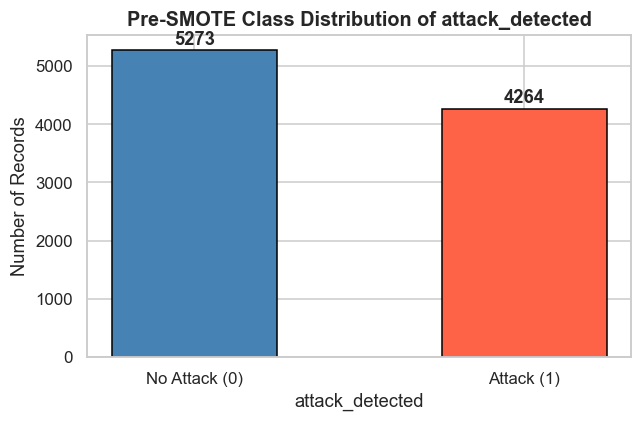

Plot saved as class_imbalance_pre_smote.png


In [ ]:
# ── Visualise Pre-SMOTE Imbalance ─────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(['No Attack (0)', 'Attack (1)'], class_counts.values,
              color=['steelblue', 'tomato'], edgecolor='black', width=0.5)

# Add count labels on bars
for bar, count in zip(bars, class_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
            str(count), ha='center', va='bottom', fontweight='bold')

ax.set_title('Pre-SMOTE Class Distribution of attack_detected', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Records')
ax.set_xlabel('attack_detected')
plt.tight_layout()
plt.savefig('class_imbalance_pre_smote.png', dpi=120)
plt.show()
print('Plot saved as class_imbalance_pre_smote.png')

In [ ]:
# ── Apply SMOTE to balance the classes ───────────────────────────────────────
# IMPORTANT: In practice, SMOTE should ONLY be applied to the TRAINING set
# (after a train/test split). We apply it here on the full dataset
# purely for EDA demonstration as required by the coursework.

X = df.drop(columns=['attack_detected'])
y = df['attack_detected']

print("Missing values per column:")
print(X.isnull().sum())
print(f"\nTotal missing values: {X.isnull().sum().sum()}")


print("Data types:")
print(X.dtypes)
print(f"\nAny non-numeric columns: {X.select_dtypes(include='object').columns.tolist()}")




print("Data types:")
print(X.dtypes)
print(f"\nAny non-numeric columns: {X.select_dtypes(include='object').columns.tolist()}")

# Convert boolean columns (from get_dummies) to integers
X = X.astype(float)

X = X.fillna(0)

print("Data types after cleaning:")
print(X.dtypes)
print(f"\nMissing values after cleaning: {X.isnull().sum().sum()}")
print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Class distribution:\n{y.value_counts()}")

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

print('✓ SMOTE applied successfully!')
print('\nPost-SMOTE Class Distribution:')
print(pd.Series(y_balanced).value_counts())

# Rebuild balanced dataframe for further EDA
df_balanced = pd.DataFrame(X_balanced, columns=X.columns)
df_balanced['attack_detected'] = y_balanced

Missing values per column:
network_packet_size        0
login_attempts             0
session_duration           0
ip_reputation_score        0
failed_logins              0
unusual_time_access        0
encryption_encoded      1966
protocol_type_TCP          0
protocol_type_UDP          0
browser_type_Edge          0
browser_type_Firefox       0
browser_type_Safari        0
browser_type_Unknown       0
dtype: int64

Total missing values: 1966
Data types:
network_packet_size     float64
login_attempts          float64
session_duration        float64
ip_reputation_score     float64
failed_logins           float64
unusual_time_access     float64
encryption_encoded      float64
protocol_type_TCP          bool
protocol_type_UDP          bool
browser_type_Edge          bool
browser_type_Firefox       bool
browser_type_Safari        bool
browser_type_Unknown       bool
dtype: object

Any non-numeric columns: []
Data types:
network_packet_size     float64
login_attempts          float64
session_

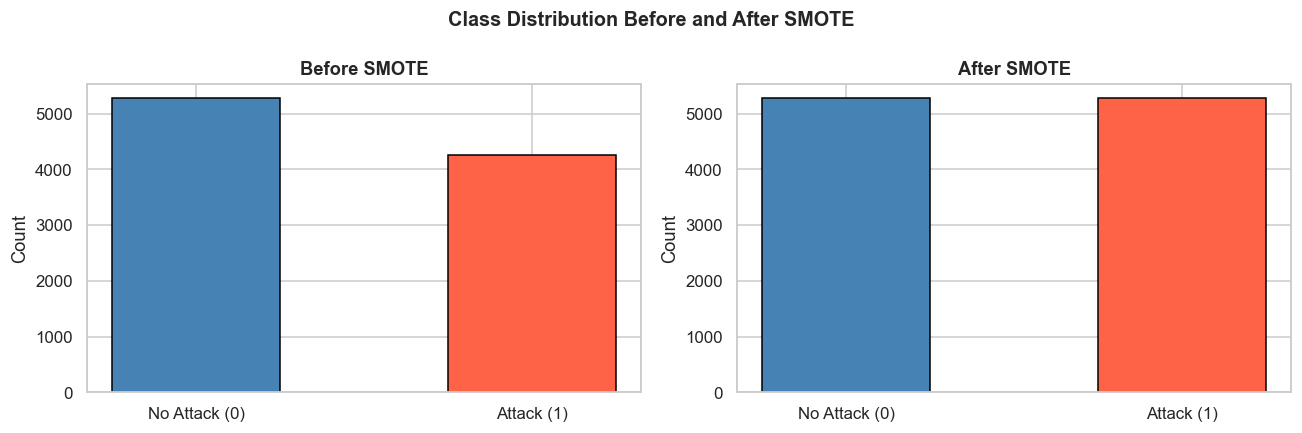

Plot saved as class_balance_comparison.png


In [ ]:
# ── Visualise Post-SMOTE Balance ──────────────────────────────────────────────
post_counts = pd.Series(y_balanced).value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before SMOTE
axes[0].bar(['No Attack (0)', 'Attack (1)'], class_counts.values,
            color=['steelblue', 'tomato'], edgecolor='black', width=0.5)
axes[0].set_title('Before SMOTE', fontweight='bold')
axes[0].set_ylabel('Count')

# After SMOTE
axes[1].bar(['No Attack (0)', 'Attack (1)'], post_counts.values,
            color=['steelblue', 'tomato'], edgecolor='black', width=0.5)
axes[1].set_title('After SMOTE', fontweight='bold')
axes[1].set_ylabel('Count')

plt.suptitle('Class Distribution Before and After SMOTE', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('class_balance_comparison.png', dpi=120)
plt.show()
print('Plot saved as class_balance_comparison.png')

Statistical EDA & Hypothesis Testing

Visualisations tell us "what" the data looks like. Statistical tests tell us "whether what we see is real or just random noise". We use p-values throughout: if "p < 0.05", the relationship is statistically significant.

Distribution of Numerical Features

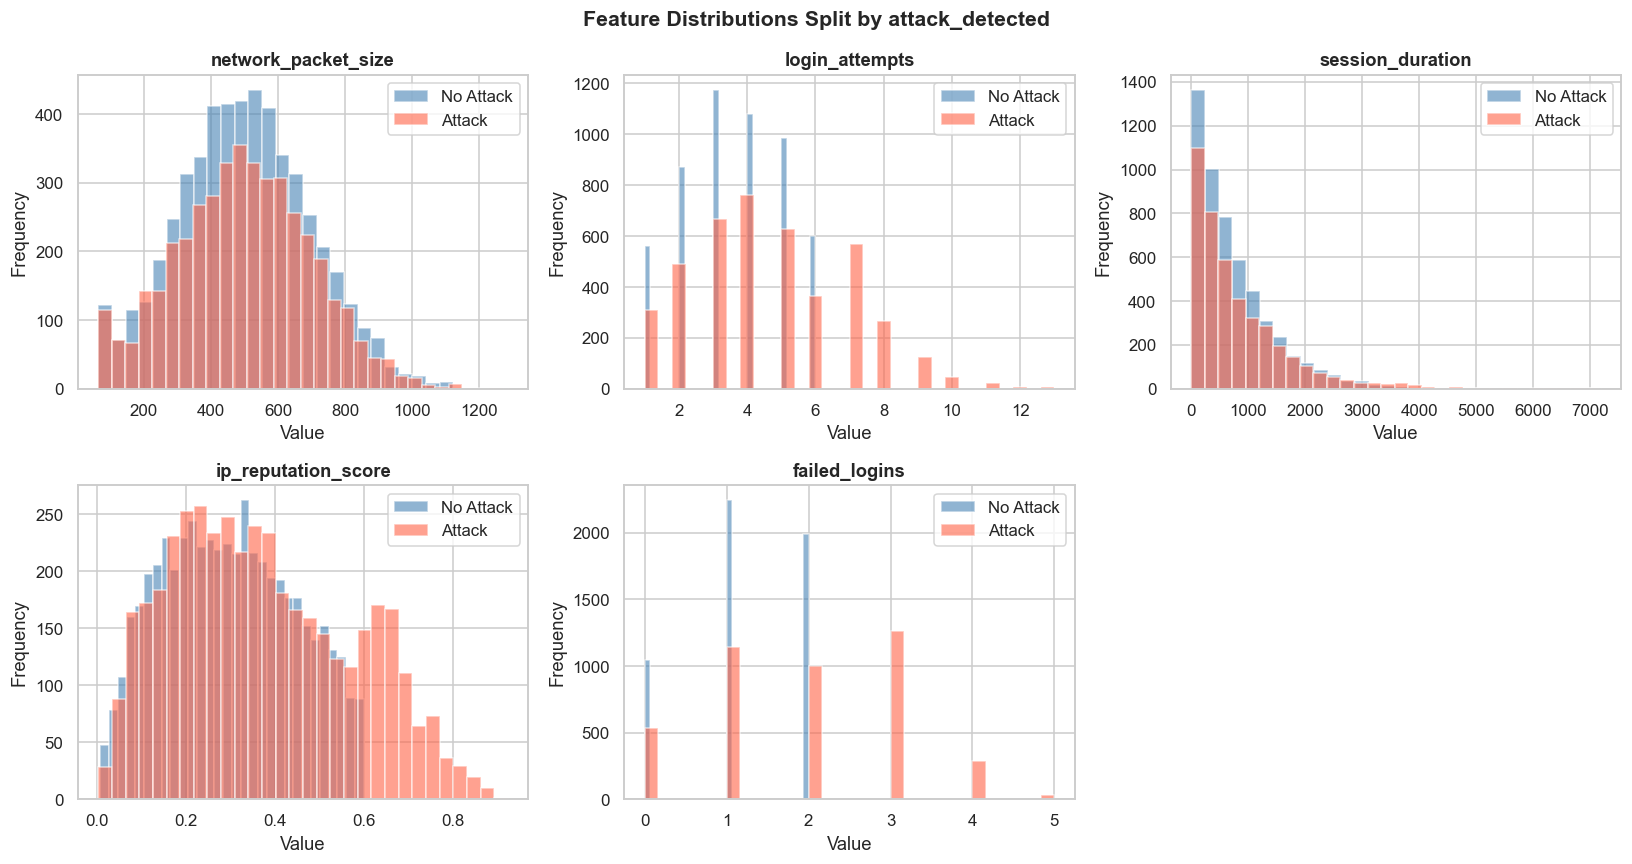

In [ ]:
# Histograms for each numerical feature 
num_features = ['network_packet_size', 'login_attempts', 'session_duration',
                'ip_reputation_score', 'failed_logins']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(num_features):
    # Plot distribution split by class
    df[df['attack_detected']==0][col].hist(ax=axes[i], bins=30, alpha=0.6,
                                            color='steelblue', label='No Attack')
    df[df['attack_detected']==1][col].hist(ax=axes[i], bins=30, alpha=0.6,
                                            color='tomato',    label='Attack')
    axes[i].set_title(col, fontweight='bold')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

# Hide unused subplot
axes[-1].set_visible(False)

plt.suptitle('Feature Distributions Split by attack_detected', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=120)
plt.show()

Correlation Heatmap

A heatmap shows which features are correlated with each other and with the target. However, we "must" follow up with p-values to confirm significance.

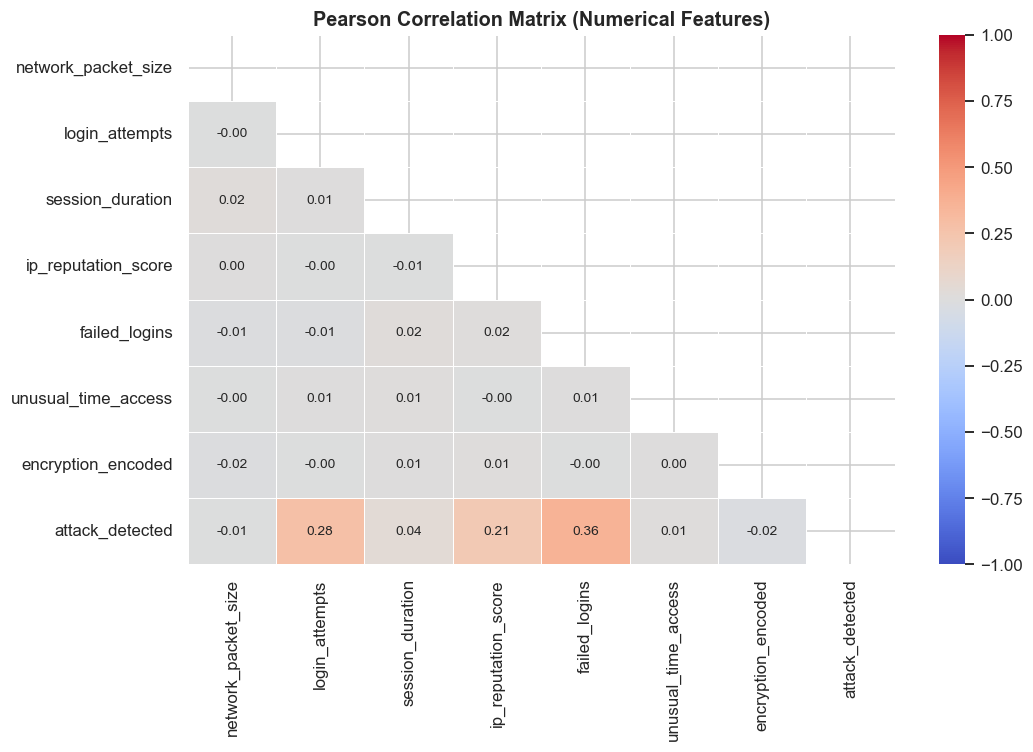

In [ ]:
#Correlation Matrix Heatmap
# Use only the original (pre-SMOTE) numerical columns for interpretability
corr_cols = ['network_packet_size', 'login_attempts', 'session_duration',
             'ip_reputation_score', 'failed_logins', 'unusual_time_access',
             'encryption_encoded', 'attack_detected']

corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 7))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # show only lower triangle
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            mask=mask, vmin=-1, vmax=1,
            linewidths=0.5, annot_kws={'size': 9})
plt.title('Pearson Correlation Matrix (Numerical Features)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=120)
plt.show()

Pearson Correlation with P-Values (Numerical Features vs Target)

In [ ]:
# Pearson Correlation + P-value for each numerical feature vs attack_detected
print('=' * 65)
print(f'{"Feature":<25} {"Correlation":>12} {"P-value":>12} {"Significant?":>12}')
print('=' * 65)

target = df['attack_detected']
results = []

for col in ['network_packet_size', 'login_attempts', 'session_duration',
            'ip_reputation_score', 'failed_logins', 'unusual_time_access',
            'encryption_encoded']:
    corr, p_val = stats.pearsonr(df[col], target)
    sig = '✓ YES' if p_val < 0.05 else '✗ NO'
    results.append({'Feature': col, 'Correlation': corr, 'P-value': p_val, 'Significant': sig})
    print(f'{col:<25} {corr:>12.4f} {p_val:>12.2e} {sig:>12}')

print('=' * 65)
print('\nInterpretation: p < 0.05 means there is a statistically significant')
print('linear relationship between the feature and attack_detected.')
results_df = pd.DataFrame(results)
results_df

Feature                    Correlation      P-value Significant?
network_packet_size            -0.0068     5.07e-01         ✗ NO
login_attempts                  0.2773    5.99e-168        ✓ YES
session_duration                0.0416     4.82e-05        ✓ YES
ip_reputation_score             0.2115     6.25e-97        ✓ YES
failed_logins                   0.3637    3.44e-296        ✓ YES
unusual_time_access             0.0087     3.98e-01         ✗ NO
encryption_encoded                 nan          nan         ✗ NO

Interpretation: p < 0.05 means there is a statistically significant
linear relationship between the feature and attack_detected.


,Feature,Correlation,P-value,Significant
0,network_packet_size,-0.006798,5.068236e-01,✗ NO
1,login_attempts,0.277320,5.989174e-168,✓ YES
2,session_duration,0.041602,4.824628e-05,✓ YES
3,ip_reputation_score,0.211540,6.247968e-97,✓ YES
4,failed_logins,0.363726,3.444839e-296,✓ YES
5,unusual_time_access,0.008652,3.982273e-01,✗ NO
6,encryption_encoded,NaN,NaN,✗ NO


Independent Samples T-Test

A "T-test" compares the 'mean' of a feature between the two classes (attack vs no attack). If the means differ significantly (p < 0.05), the feature helps distinguish attacks from normal traffic.

In [ ]:
# Independent T-test: Attack group vs No-Attack group 
attack_group    = df[df['attack_detected'] == 1]
no_attack_group = df[df['attack_detected'] == 0]

print('=' * 70)
print(f'{"Feature":<25} {"Mean (Attack)":>14} {"Mean (No Attack)":>17} {"P-value":>10} {"Sig?":>6}')
print('=' * 70)

ttest_results = []
for col in ['network_packet_size', 'login_attempts', 'session_duration',
            'ip_reputation_score', 'failed_logins']:
    t_stat, p_val = stats.ttest_ind(attack_group[col], no_attack_group[col], equal_var=False)
    mean_att = attack_group[col].mean()
    mean_no  = no_attack_group[col].mean()
    sig = '✓' if p_val < 0.05 else '✗'
    ttest_results.append({'Feature': col, 'Mean_Attack': mean_att,
                          'Mean_No_Attack': mean_no, 'P_value': p_val, 'Sig': sig})
    print(f'{col:<25} {mean_att:>14.3f} {mean_no:>17.3f} {p_val:>10.2e} {sig:>6}')

print('=' * 70)
print('Welch T-test (equal_var=False) is used to handle unequal group variances.')

Feature                    Mean (Attack)  Mean (No Attack)    P-value   Sig?
network_packet_size              498.931           501.643   5.07e-01      ✗
login_attempts                     4.637             3.543  1.72e-153      ✓
session_duration                 829.132           763.321   6.40e-05      ✓
ip_reputation_score                0.373             0.298   8.99e-91      ✓
failed_logins                      1.936             1.180  5.24e-265      ✓
Welch T-test (equal_var=False) is used to handle unequal group variances.


In [ ]:
import seaborn as sns
print(sns.__version__)

0.13.2


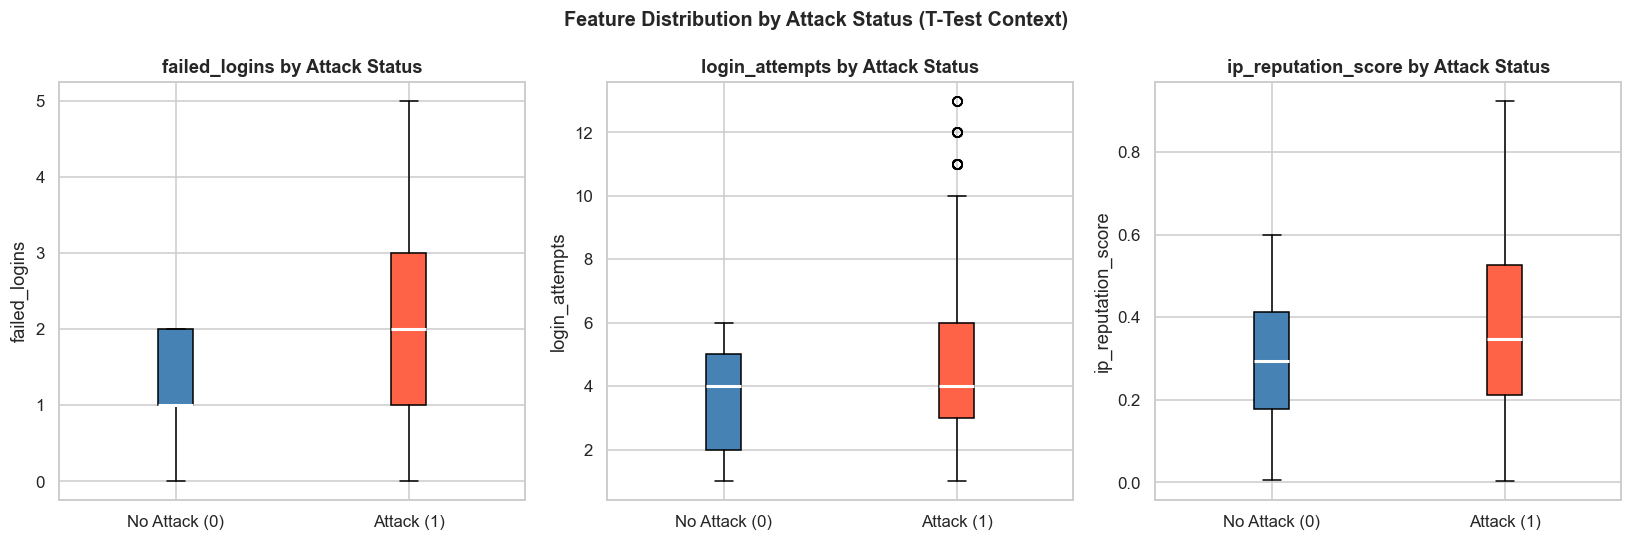

✓ Plot saved as ttest_boxplots.png


In [ ]:
# Box plots to visualise T-test findings

# Make sure attack_detected is string type
df['attack_detected'] = df['attack_detected'].astype(str)

# Create the figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through each feature and its subplot
for ax, col in zip(axes, ['failed_logins', 'login_attempts', 'ip_reputation_score']):

    # Split data by class
    group0 = df[df['attack_detected'] == '0'][col]
    group1 = df[df['attack_detected'] == '1'][col]

    # Draw boxplot using tick_labels (renamed from labels in Matplotlib 3.9)
    bp = ax.boxplot(
        [group0, group1],
        patch_artist=True,
        tick_labels=['No Attack (0)', 'Attack (1)']  # ← changed from labels
    )

    # Apply colours to the two boxes
    bp['boxes'][0].set_facecolor('steelblue')
    bp['boxes'][1].set_facecolor('tomato')

    # Style the median lines
    for median in bp['medians']:
        median.set_color('white')
        median.set_linewidth(2)

    ax.set_title(f'{col} by Attack Status', fontweight='bold')
    ax.set_ylabel(col)

plt.suptitle('Feature Distribution by Attack Status (T-Test Context)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('ttest_boxplots.png', dpi=120)
plt.show()
print('✓ Plot saved as ttest_boxplots.png')

# Convert attack_detected back to integer after plotting
df['attack_detected'] = df['attack_detected'].astype(int)

#3.5  Chi-Square Test (Categorical Features vs Target)

For categorical features, we use Chi-Square test to check if there is a significant association between the category and the target variable.

In [ ]:
# Reload original (pre-encoded) data for Chi-Square 
df_original = pd.read_csv('cybersecurity_intrusion_data.csv')

print('Chi-Square Test Results\n' + '=' * 60)
print(f'{"Categorical Feature":<25} {"Chi2":>10} {"P-value":>12} {"Significant?":>13}')
print('=' * 60)

chi2_results = []
for col in ['protocol_type', 'encryption_used', 'browser_type', 'unusual_time_access']:
    contingency = pd.crosstab(df_original[col], df_original['attack_detected'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency)
    sig = '✓ YES' if p < 0.05 else '✗ NO'
    chi2_results.append({'Feature': col, 'Chi2': chi2, 'P_value': p, 'Significant': sig})
    print(f'{col:<25} {chi2:>10.3f} {p:>12.2e} {sig:>13}')

print('=' * 60)
print('\nInterpretation: p < 0.05 means the category is NOT independent of')
print('attack_detected — it has a meaningful relationship with attacks.')

Chi-Square Test Results
Categorical Feature             Chi2      P-value  Significant?
protocol_type                  2.941     2.30e-01          ✗ NO
encryption_used                1.952     1.62e-01          ✗ NO
browser_type                 173.801     1.60e-36         ✓ YES
unusual_time_access            0.666     4.14e-01          ✗ NO

Interpretation: p < 0.05 means the category is NOT independent of
attack_detected — it has a meaningful relationship with attacks.


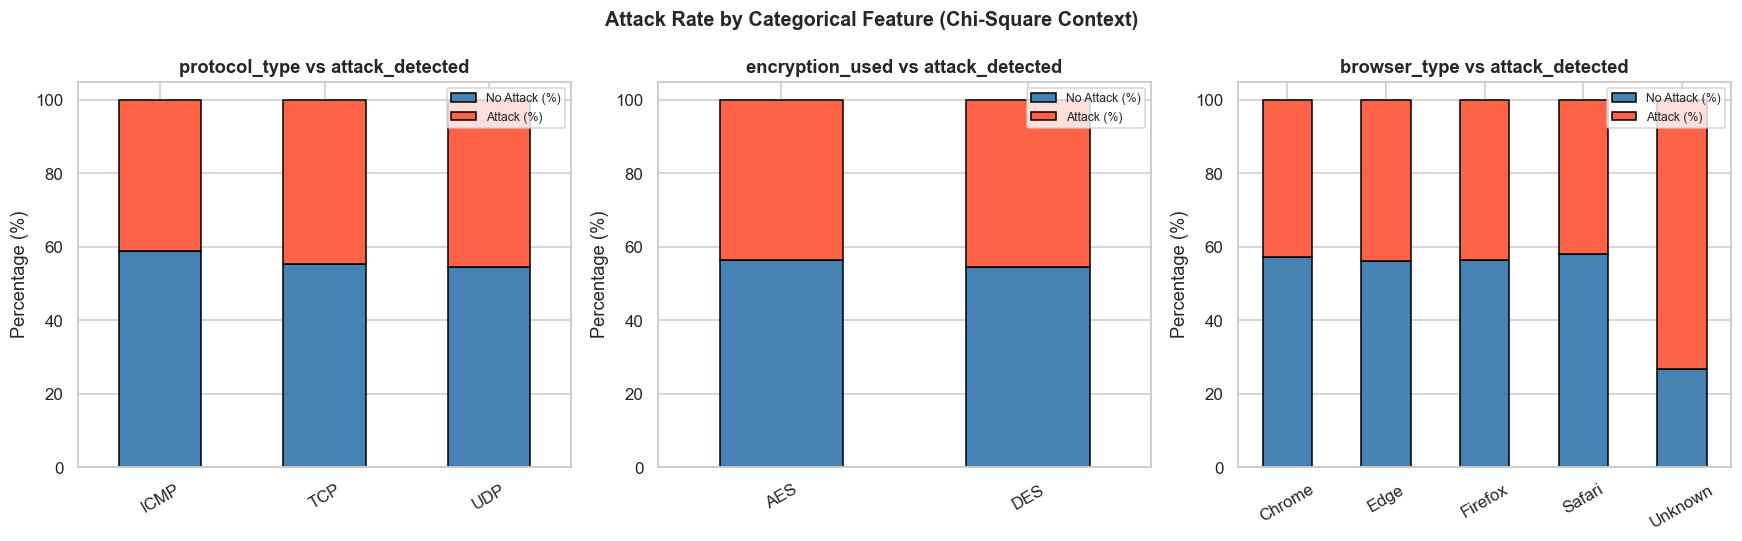

In [ ]:
# Stacked bar charts for categorical features vs attack status 
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, col in zip(axes, ['protocol_type', 'encryption_used', 'browser_type']):
    ct = pd.crosstab(df_original[col], df_original['attack_detected'], normalize='index') * 100
    ct.columns = ['No Attack (%)', 'Attack (%)']
    ct.plot(kind='bar', stacked=True, ax=ax,
            color=['steelblue', 'tomato'], edgecolor='black')
    ax.set_title(f'{col} vs attack_detected', fontweight='bold')
    ax.set_ylabel('Percentage (%)')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=30)
    ax.legend(loc='upper right', fontsize=8)

plt.suptitle('Attack Rate by Categorical Feature (Chi-Square Context)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('chisquare_stacked_bars.png', dpi=120)
plt.show()

### 3.6  Feature Importance Summary – Which Features to Keep?

In [ ]:
# Summary table combining all statistical test results 
summary = pd.DataFrame([
    {'Feature': 'network_packet_size', 'Test': 'Pearson',    'Significant': 'Check above', 'Action': 'Keep if p<0.05'},
    {'Feature': 'login_attempts',      'Test': 'Pearson',    'Significant': 'Check above', 'Action': 'Keep if p<0.05'},
    {'Feature': 'session_duration',    'Test': 'Pearson',    'Significant': 'Check above', 'Action': 'Keep if p<0.05'},
    {'Feature': 'ip_reputation_score', 'Test': 'Pearson',    'Significant': 'Check above', 'Action': 'Keep if p<0.05'},
    {'Feature': 'failed_logins',       'Test': 'T-test',     'Significant': 'Check above', 'Action': 'Keep if p<0.05'},
    {'Feature': 'protocol_type',       'Test': 'Chi-Square', 'Significant': 'Check above', 'Action': 'Keep if p<0.05'},
    {'Feature': 'encryption_used',     'Test': 'Chi-Square', 'Significant': 'Check above', 'Action': 'Keep if p<0.05'},
    {'Feature': 'browser_type',        'Test': 'Chi-Square', 'Significant': 'Check above', 'Action': 'Keep if p<0.05'},
    {'Feature': 'unusual_time_access', 'Test': 'Chi-Square', 'Significant': 'Check above', 'Action': 'Keep if p<0.05'},
])

print('Feature Retention Strategy:')
print(summary.to_string(index=False))
print('\n✓ Features with p < 0.05 from any test are statistically justified for modelling.')
print('✗ Features with p >= 0.05 should be dropped to reduce overfitting risk.')

Feature Retention Strategy:
            Feature       Test Significant         Action
network_packet_size    Pearson Check above Keep if p<0.05
     login_attempts    Pearson Check above Keep if p<0.05
   session_duration    Pearson Check above Keep if p<0.05
ip_reputation_score    Pearson Check above Keep if p<0.05
      failed_logins     T-test Check above Keep if p<0.05
      protocol_type Chi-Square Check above Keep if p<0.05
    encryption_used Chi-Square Check above Keep if p<0.05
       browser_type Chi-Square Check above Keep if p<0.05
unusual_time_access Chi-Square Check above Keep if p<0.05

✓ Features with p < 0.05 from any test are statistically justified for modelling.
✗ Features with p >= 0.05 should be dropped to reduce overfitting risk.


Summary & Conclusions

What We Did

1. Theoretical Grounding: Mapped 7 dataset features to the CIA Triad and Cyber Kill Chain framework, justifying why each feature should theoretically influence attack detection.

2. Advanced Preprocessing:
   - Discussed MCAR vs MNAR in the context of cybersecurity logs
   - Applied "KNN Imputation" (better than simple mean/median)
   - Used "Ordinal Label Encoding" for 'encryption_used' (None < DES < AES)
   - Used "One-Hot Encoding" for 'protocol_type' and 'browser_type' (nominal categories)
   - Detected and addressed class imbalance using "SMOTE."

3. Statistical EDA:
   - Plotted feature distributions split by class
   - Built a "Pearson correlation heatmap" with p-values to assess numerical feature relevance
   - Ran "Welch T-tests" to compare group means for attack vs no-attack sessions
   - Ran "Chi-Square tests" for all categorical features
   - Visualised findings with box plots and stacked bar charts

